# Grover FoM Conditional Run Demo

We want to run a simple circuit (e.g., a Φ⁺ Bell state) **only if** the backend shows adequate Grover performance.
Grover FoM (GRADE) measures how well a device concentrates probability on marked states while penalizing dispersion and leaks to non-targets.

In this notebook we will:

1. **Define the Grover FoM** (choose number of targets (M), λ and μ; enforce **n ≥ 2** qubits).
2. **Set a score threshold** (e.g., `score > 0.2`) to decide if the backend is “good enough”.
3. **Pick a backend adapter** (Aer or IBM). not checked for IONQ and others.
4. **Configure a compliance check** that evaluates Grover and compares the score to the threshold.
5. **Run conditionally**: if the check **passes**, execute our target circuit (Φ⁺); otherwise run a fallback.
6. **Inspect metrics** (`P_T`, `σ_T`, `P_N`, `score`) and visualize basic results. Visualization can be seen in *Graph FoM*

> Benchmark note: to match literature conventions, keep **transpiler optimization offs** (`optimization_level=0`).


In [15]:
import os

from qiskit import QuantumCircuit

from qonscious import run_conditionally
from qonscious.actions import QonsciousCallable
from qonscious.adapters import AerSamplerAdapter, IonQBackendAdapter
from qonscious.checks import MeritComplianceCheck
from qonscious.foms import GroverFigureOfMerit

In [16]:
def phi_plus(): #build a sample circuit, can be any circuit
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure([0, 1], [0, 1])
    return qc

In [17]:
from qonscious.adapters import BackendAdapter


def on_pass(backend_adapter : BackendAdapter, figureOfMeritResults):
    firstFoMResult = figureOfMeritResults[0]
    print("Grover FoM passed the compliance check!")
    print(f"Score: {firstFoMResult['properties']['score']:.3f}")
    print("Running our Phi+ circuit")
    run_result = backend_adapter.run(phi_plus(), shots=2048)
    print("Phi+ circuit finished running")
    return run_result

# Este seria el No Op en caso de fallo
fallback = QonsciousCallable(
    lambda adapter, fom_results, **kwargs: None,
)


In [18]:
#Mandatory Grover FoM variables
N_TARGETS =1
L_FACTOR = 0
MU_FACTOR = 0
fom = GroverFigureOfMerit(
    num_targets=N_TARGETS,
    lambda_factor=L_FACTOR,
    mu_factor=MU_FACTOR,
    num_qubits=3,  # Optionally specify number of qubits to build the search space. If not provided 2 is the minimum.
    #targets_int=[3], # Targets can be specified manually eg. to search for '00000'
)

In [19]:
THRESHOLD = 0
def grade_score_over(threshold: float):
    """Función de utilidad para verificar el score GRADE en 'properties'."""
    # Retorna una función lambda que toma el resultado del FoM (r)
    return lambda r: r["properties"]["score"] > threshold

check_grover_is_ok = MeritComplianceCheck(
    figure_of_merit=fom,
    decision_function=lambda r: r["properties"]["score"] > THRESHOLD,
)


In [20]:
#backend_adapter = AerSamplerAdapter()
#backend_adapter = IBMSamplerAdapter(FakeManilaV2()) # edit as needed
#backend_adapter = IBMSamplerAdapter(FakeTorino()) # edit as needed

api_key = "zX6nxTjXeClRj930SzRVRV3IrP6yg2NQ"
backend_adapter = IonQBackendAdapter.aria_simulator(api_key)

qonscious_result = run_conditionally(
    backend_adapter=backend_adapter,
    checks=[check_grover_is_ok],
    on_pass=QonsciousCallable(on_pass),
    on_fail=fallback,
)

Grover FoM passed the compliance check!
Score: 0.773
Running our Phi+ circuit
Phi+ circuit finished running


# Graph FoM
**debug ONLY**, shouldn't be available in final version.

Propiedades: {'num_qubits': 3, 'search_space_size': 8, 'targets_count': 1, 'grover_iterations': 2, 'target_states': ['010'], 'lambda_factor': 0.0, 'mu_factor': 0.0, 'shots': 1000, 'score': 0.773, 'P_T': 0.773, 'sigma_T': 0.0, 'P_N': 0.22699999999999998}
n = 3 counts keys: ['000', '001', '010', '011', '100', '101', '110', '111']


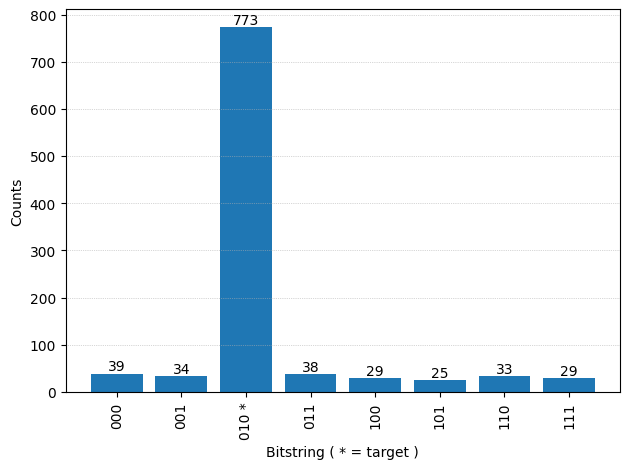

In [21]:
import matplotlib.pyplot as plt

foms = qonscious_result["figures_of_merit_results"]
firstfom = foms[0]
# La impresion quedo rarisima, asi que debe hacerse mejor, cambiar FOM para que tenga un metodo de impresion?
props = firstfom["properties"]
n = props["num_qubits"]
print("Propiedades:", props)
targets = set(props.get("target_states", []) or [])  # ← acá están los targets
# counts = del experimento del FoM (NO del on_pass)
exp = firstfom.get("experiment_result") or {}
counts = exp["counts"] if isinstance(exp, dict) else getattr(exp, "counts", {})
print("n =", n, "counts keys:", sorted(counts.keys())[:10])
labels = [format(i, f'0{n}b') for i in range(2**n)]
values = [counts.get(b, 0) for b in labels]
tick_labels = [lbl + (" *" if lbl in targets else "") for lbl in labels]

fig, ax = plt.subplots()
bars = ax.bar(range(len(labels)), values)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_ylabel("Counts"); ax.set_xlabel("Bitstring ( * = target )")
ax.grid(True, axis='y', linestyle=':', linewidth=0.5)
for i, bar in enumerate(bars):
    v = values[i]
    if v: ax.text(bar.get_x()+bar.get_width()/2, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()



In [22]:
import math

import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.visualization import circuit_drawer
from qiskit_aer import AerSimulator


# --- R óptimo (evita overshoot) ---
def optimal_rounds(N: int, M: int) -> int:
    if M <= 0 or M >= N:
        return 0
    theta = math.asin(math.sqrt(M / N))
    R = int(math.floor((math.pi / (4*theta)) - 0.5))
    return max(0, R)

# --- Oráculo multi-target (endianness corregido) ---
def oracle_mt(targets_bin: list[str], n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="Oracle")
    tgt = n - 1  # qubit objetivo para MCZ
    for t in targets_bin:
        bits_le = list(reversed(t))                      # Qiskit: qubit 0 es LSB
        zeros = [i for i,b in enumerate(bits_le) if b=='0']
        for i in zeros: qc.x(i)                          # pre-conditioning
        qc.h(tgt); qc.mcx(list(range(n-1)), tgt); qc.h(tgt) if n>1 else qc.x(tgt)
        for i in zeros: qc.x(i)                          # post-conditioning
    return qc

# --- Difusor de Grover ---
def diffuser(n: int) -> QuantumCircuit:
    dq = QuantumCircuit(n, name="Diffusion")
    dq.h(range(n)); dq.x(range(n))
    if n>1:
        dq.h(n-1); dq.mcx(list(range(n-1)), n-1); dq.h(n-1)
    else:
        dq.z(0)
    dq.x(range(n)); dq.h(range(n))
    return dq

# --- Construcción del circuito completo ---
def build_grover(n: int, targets_bin: list[str], R: int|None=None, measure=True):
    N = 2**n
    M = len(targets_bin)
    R = optimal_rounds(N, M) if R is None else R

    qc = QuantumCircuit(n, n if measure else 0, name="Grover")
    qc.h(range(n))
    U = oracle_mt(targets_bin, n)
    D = diffuser(n)
    for _ in range(R):
        qc.compose(U, range(n), inplace=True)
        qc.compose(D, range(n), inplace=True)
        qc.barrier()
    if measure:
        qc.measure(range(n), range(n))
    return qc, U, D, R

# ===== Ejemplo: n=4, targets 0000 y 1001 =====
n = 4
targets = ["1011"]
qc, U, D, R = build_grover(n, targets, R=None, measure=True)

print(f"n={n}, targets={targets}, R={R}\n")

print("=== ORÁCULO ===")
print(U.draw(output="text", idle_wires=False))

print("\n=== DIFUSOR ===")
print(D.draw(output="text", idle_wires=False))

print("\n=== CIRCUITO COMPLETO ===")
print(qc.draw())

# (Opcional) ver el circuito transpiled a las compuertas del simulador
sim = AerSimulator()
tqc = transpile(qc, sim, optimization_level=0)
print("\n=== CIRCUITO TRANSPILE ===")
print(tqc.draw(output="text", idle_wires=False, cregbundle=True))



circuit_drawer(qc, output="mpl", fold=-1)   # fold=-1 para no partir líneas
plt.show()

n=4, targets=['1011'], R=2

=== ORÁCULO ===
                    
q_0: ───────■───────
            │       
q_1: ───────■───────
     ┌───┐  │  ┌───┐
q_2: ┤ X ├──■──┤ X ├
     ├───┤┌─┴─┐├───┤
q_3: ┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘

=== DIFUSOR ===
     ┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_2: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_3: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

=== CIRCUITO COMPLETO ===
     ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐      ░           ┌───┐»
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────░────────■──┤ H ├»
     ├───┤       │  ├───┤├───┤            │  ├───┤├───┤      ░        │  ├───┤»
q_1: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────░────────■──┤ H ├»
     ├───┤┌───┐  │  ├───┤├───┤┌───